In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
def sample(buffer, batch_size):
    idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
    return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [16]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [17]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [18]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.3882 dloss:0.5882 aloss2:1.7659 exploreP:0.9990
Episode:1 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.3884 dloss:0.5866 aloss2:1.8130 exploreP:0.9980
Episode:2 meanR:14.3333 R:23.0000 rate:0.0460 aloss:1.3907 dloss:0.5704 aloss2:1.9420 exploreP:0.9958
Episode:3 meanR:14.2500 R:14.0000 rate:0.0280 aloss:1.4130 dloss:0.5704 aloss2:1.8406 exploreP:0.9944
Episode:4 meanR:17.6000 R:31.0000 rate:0.0620 aloss:1.3809 dloss:0.5634 aloss2:1.9964 exploreP:0.9913
Episode:5 meanR:18.1667 R:21.0000 rate:0.0420 aloss:1.3854 dloss:0.5572 aloss2:2.0570 exploreP:0.9893
Episode:6 meanR:18.1429 R:18.0000 rate:0.0360 aloss:1.3796 dloss:0.5543 aloss2:2.0881 exploreP:0.9875
Episode:7 meanR:17.5000 R:13.0000 rate:0.0260 aloss:1.3837 dloss:0.5466 aloss2:2.1334 exploreP:0.9862
Episode:8 meanR:17.4444 R:17.0000 rate:0.0340 aloss:1.3797 dloss:0.5471 aloss2:2.1623 exploreP:0.9846
Episode:9 meanR:17.4000 R:17.0000 rate:0.0340 aloss:1.3808 dloss:0.5440 aloss2:2.1

Episode:80 meanR:27.3210 R:11.0000 rate:0.0220 aloss:1.3576 dloss:0.3999 aloss2:8.3052 exploreP:0.8035
Episode:81 meanR:27.2073 R:18.0000 rate:0.0360 aloss:1.3670 dloss:0.3730 aloss2:8.7747 exploreP:0.8020
Episode:82 meanR:27.3253 R:37.0000 rate:0.0740 aloss:1.3640 dloss:0.3683 aloss2:8.7626 exploreP:0.7991
Episode:83 meanR:27.2024 R:17.0000 rate:0.0340 aloss:1.3653 dloss:0.3830 aloss2:8.7826 exploreP:0.7978
Episode:84 meanR:27.6353 R:64.0000 rate:0.1280 aloss:1.3676 dloss:0.3743 aloss2:8.6948 exploreP:0.7927
Episode:85 meanR:28.0698 R:65.0000 rate:0.1300 aloss:1.3653 dloss:0.3846 aloss2:8.6280 exploreP:0.7877
Episode:86 meanR:28.8391 R:95.0000 rate:0.1900 aloss:1.3717 dloss:0.3758 aloss2:8.7362 exploreP:0.7803
Episode:87 meanR:29.2159 R:62.0000 rate:0.1240 aloss:1.3730 dloss:0.3690 aloss2:8.7813 exploreP:0.7756
Episode:88 meanR:29.6180 R:65.0000 rate:0.1300 aloss:1.3626 dloss:0.3803 aloss2:8.7584 exploreP:0.7706
Episode:89 meanR:29.5889 R:27.0000 rate:0.0540 aloss:1.3763 dloss:0.3689 

Episode:159 meanR:62.9400 R:123.0000 rate:0.2460 aloss:1.3763 dloss:0.3896 aloss2:8.2087 exploreP:0.4670
Episode:160 meanR:64.2900 R:157.0000 rate:0.3140 aloss:1.3781 dloss:0.3926 aloss2:8.0949 exploreP:0.4599
Episode:161 meanR:64.1900 R:113.0000 rate:0.2260 aloss:1.3779 dloss:0.3858 aloss2:8.2285 exploreP:0.4548
Episode:162 meanR:65.0100 R:102.0000 rate:0.2040 aloss:1.3704 dloss:0.4156 aloss2:8.1015 exploreP:0.4503
Episode:163 meanR:66.6200 R:179.0000 rate:0.3580 aloss:1.3763 dloss:0.3943 aloss2:7.9512 exploreP:0.4425
Episode:164 meanR:67.6000 R:118.0000 rate:0.2360 aloss:1.3754 dloss:0.3940 aloss2:8.0618 exploreP:0.4374
Episode:165 meanR:69.3000 R:219.0000 rate:0.4380 aloss:1.3743 dloss:0.3988 aloss2:8.0376 exploreP:0.4282
Episode:166 meanR:70.6400 R:162.0000 rate:0.3240 aloss:1.3742 dloss:0.4064 aloss2:7.9080 exploreP:0.4215
Episode:167 meanR:71.3400 R:83.0000 rate:0.1660 aloss:1.3728 dloss:0.4108 aloss2:7.8475 exploreP:0.4181
Episode:168 meanR:72.7200 R:157.0000 rate:0.3140 aloss:1

Episode:237 meanR:169.9400 R:260.0000 rate:0.5200 aloss:1.3760 dloss:0.5222 aloss2:5.5960 exploreP:0.1127
Episode:238 meanR:171.6400 R:257.0000 rate:0.5140 aloss:1.3738 dloss:0.4902 aloss2:5.5621 exploreP:0.1101
Episode:239 meanR:172.6700 R:260.0000 rate:0.5200 aloss:1.3738 dloss:0.5037 aloss2:5.6424 exploreP:0.1075
Episode:240 meanR:175.1400 R:282.0000 rate:0.5640 aloss:1.3732 dloss:0.5345 aloss2:5.4808 exploreP:0.1048
Episode:241 meanR:178.4200 R:500.0000 rate:1.0000 aloss:1.3779 dloss:0.5192 aloss2:5.4035 exploreP:0.1002
Episode:242 meanR:180.4600 R:244.0000 rate:0.4880 aloss:1.3734 dloss:0.5372 aloss2:5.1362 exploreP:0.0980
Episode:243 meanR:183.4400 R:330.0000 rate:0.6600 aloss:1.3764 dloss:0.5235 aloss2:5.1176 exploreP:0.0952
Episode:244 meanR:186.5400 R:359.0000 rate:0.7180 aloss:1.3774 dloss:0.5161 aloss2:5.1155 exploreP:0.0922
Episode:245 meanR:188.1800 R:199.0000 rate:0.3980 aloss:1.3757 dloss:0.5353 aloss2:5.0607 exploreP:0.0905
Episode:246 meanR:189.9600 R:219.0000 rate:0.4

Episode:315 meanR:300.5700 R:245.0000 rate:0.4900 aloss:1.3121 dloss:0.6423 aloss2:2.3747 exploreP:0.0190
Episode:316 meanR:300.3900 R:163.0000 rate:0.3260 aloss:1.3076 dloss:0.6403 aloss2:2.3716 exploreP:0.0189
Episode:317 meanR:300.4100 R:165.0000 rate:0.3300 aloss:1.3144 dloss:0.6270 aloss2:2.4549 exploreP:0.0187
Episode:318 meanR:302.9800 R:500.0000 rate:1.0000 aloss:1.3170 dloss:0.6332 aloss2:2.5103 exploreP:0.0183
Episode:319 meanR:303.8400 R:369.0000 rate:0.7380 aloss:1.3069 dloss:0.6414 aloss2:2.3884 exploreP:0.0180
Episode:320 meanR:306.6600 R:500.0000 rate:1.0000 aloss:1.2996 dloss:0.6458 aloss2:2.2885 exploreP:0.0176
Episode:321 meanR:307.9600 R:399.0000 rate:0.7980 aloss:1.3036 dloss:0.6401 aloss2:2.1882 exploreP:0.0173
Episode:322 meanR:311.1900 R:468.0000 rate:0.9360 aloss:1.3046 dloss:0.6370 aloss2:2.2924 exploreP:0.0170
Episode:323 meanR:312.7500 R:500.0000 rate:1.0000 aloss:1.3047 dloss:0.6357 aloss2:2.3354 exploreP:0.0166
Episode:324 meanR:312.9600 R:284.0000 rate:0.5

Episode:393 meanR:384.9200 R:500.0000 rate:1.0000 aloss:1.2041 dloss:0.5555 aloss2:1.0363 exploreP:0.0104
Episode:394 meanR:384.9200 R:500.0000 rate:1.0000 aloss:1.2032 dloss:0.5541 aloss2:1.0816 exploreP:0.0104
Episode:395 meanR:385.6200 R:273.0000 rate:0.5460 aloss:1.1938 dloss:0.5434 aloss2:0.8986 exploreP:0.0104
Episode:396 meanR:385.5900 R:434.0000 rate:0.8680 aloss:1.1900 dloss:0.5515 aloss2:0.8975 exploreP:0.0104
Episode:397 meanR:386.6200 R:500.0000 rate:1.0000 aloss:1.2040 dloss:0.5390 aloss2:1.0092 exploreP:0.0103
Episode:398 meanR:386.6200 R:500.0000 rate:1.0000 aloss:1.1755 dloss:0.5159 aloss2:0.7505 exploreP:0.0103
Episode:399 meanR:387.6100 R:500.0000 rate:1.0000 aloss:1.1977 dloss:0.5375 aloss2:0.9234 exploreP:0.0103
Episode:400 meanR:390.9000 R:500.0000 rate:1.0000 aloss:1.1880 dloss:0.5217 aloss2:0.8227 exploreP:0.0103
Episode:401 meanR:392.8800 R:500.0000 rate:1.0000 aloss:1.1791 dloss:0.5108 aloss2:0.7761 exploreP:0.0103
Episode:402 meanR:396.2200 R:500.0000 rate:1.0

Episode:471 meanR:480.3500 R:500.0000 rate:1.0000 aloss:1.0066 dloss:0.1672 aloss2:4.5656 exploreP:0.0100
Episode:472 meanR:480.3500 R:500.0000 rate:1.0000 aloss:1.0066 dloss:0.1368 aloss2:4.8673 exploreP:0.0100
Episode:473 meanR:480.3500 R:500.0000 rate:1.0000 aloss:1.0071 dloss:0.1568 aloss2:5.0319 exploreP:0.0100
Episode:474 meanR:483.4800 R:500.0000 rate:1.0000 aloss:1.0067 dloss:0.1345 aloss2:5.1894 exploreP:0.0100
Episode:475 meanR:483.4800 R:500.0000 rate:1.0000 aloss:1.0000 dloss:0.1206 aloss2:5.5018 exploreP:0.0100
Episode:476 meanR:483.4800 R:500.0000 rate:1.0000 aloss:0.9977 dloss:0.1254 aloss2:5.9323 exploreP:0.0100
Episode:477 meanR:486.2000 R:500.0000 rate:1.0000 aloss:0.9988 dloss:0.1025 aloss2:6.1907 exploreP:0.0100
Episode:478 meanR:486.6000 R:500.0000 rate:1.0000 aloss:0.9977 dloss:0.0977 aloss2:6.7181 exploreP:0.0100
Episode:479 meanR:486.6000 R:500.0000 rate:1.0000 aloss:0.9957 dloss:0.1218 aloss2:6.7579 exploreP:0.0100
Episode:480 meanR:490.0300 R:500.0000 rate:1.0

Episode:548 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8993 dloss:0.0181 aloss2:19.2076 exploreP:0.0100
Episode:549 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8955 dloss:0.0193 aloss2:20.5658 exploreP:0.0100
Episode:550 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8961 dloss:0.0136 aloss2:21.5311 exploreP:0.0100
Episode:551 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8934 dloss:0.0128 aloss2:22.8548 exploreP:0.0100
Episode:552 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8924 dloss:0.0107 aloss2:24.2239 exploreP:0.0100
Episode:553 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8918 dloss:0.0129 aloss2:25.4131 exploreP:0.0100
Episode:554 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8887 dloss:0.0126 aloss2:26.4951 exploreP:0.0100
Episode:555 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8900 dloss:0.0159 aloss2:26.6629 exploreP:0.0100
Episode:556 meanR:492.1900 R:500.0000 rate:1.0000 aloss:0.8846 dloss:0.0116 aloss2:27.1168 exploreP:0.0100
Episode:557 meanR:492.1900 R:500.0000

Episode:625 meanR:493.9800 R:500.0000 rate:1.0000 aloss:0.8399 dloss:0.0053 aloss2:42.1506 exploreP:0.0100
Episode:626 meanR:493.9800 R:500.0000 rate:1.0000 aloss:0.8412 dloss:0.0044 aloss2:43.4721 exploreP:0.0100
Episode:627 meanR:493.9800 R:500.0000 rate:1.0000 aloss:0.8432 dloss:0.0050 aloss2:44.2542 exploreP:0.0100
Episode:628 meanR:493.8500 R:487.0000 rate:0.9740 aloss:0.8411 dloss:0.0035 aloss2:44.3845 exploreP:0.0100
Episode:629 meanR:493.8500 R:500.0000 rate:1.0000 aloss:0.8393 dloss:0.0070 aloss2:44.5850 exploreP:0.0100
Episode:630 meanR:493.8500 R:500.0000 rate:1.0000 aloss:0.8380 dloss:0.0075 aloss2:43.5962 exploreP:0.0100
Episode:631 meanR:493.5100 R:466.0000 rate:0.9320 aloss:0.8390 dloss:0.0035 aloss2:43.0318 exploreP:0.0100
Episode:632 meanR:493.5100 R:500.0000 rate:1.0000 aloss:0.8348 dloss:0.0113 aloss2:43.3860 exploreP:0.0100
Episode:633 meanR:495.9100 R:500.0000 rate:1.0000 aloss:0.8369 dloss:0.0094 aloss2:40.0472 exploreP:0.0100
Episode:634 meanR:495.9100 R:500.0000

Episode:702 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8302 dloss:0.0031 aloss2:47.3537 exploreP:0.0100
Episode:703 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8343 dloss:0.0046 aloss2:48.4327 exploreP:0.0100
Episode:704 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8279 dloss:0.0047 aloss2:47.3352 exploreP:0.0100
Episode:705 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8289 dloss:0.0032 aloss2:48.6250 exploreP:0.0100
Episode:706 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8302 dloss:0.0039 aloss2:49.0494 exploreP:0.0100
Episode:707 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8277 dloss:0.0034 aloss2:49.9247 exploreP:0.0100
Episode:708 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8276 dloss:0.0044 aloss2:50.0583 exploreP:0.0100
Episode:709 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8281 dloss:0.0040 aloss2:49.3428 exploreP:0.0100
Episode:710 meanR:499.5300 R:500.0000 rate:1.0000 aloss:0.8289 dloss:0.0028 aloss2:50.9093 exploreP:0.0100
Episode:711 meanR:499.5300 R:500.0000

Episode:779 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8088 dloss:0.0080 aloss2:42.3752 exploreP:0.0100
Episode:780 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8082 dloss:0.0059 aloss2:43.4505 exploreP:0.0100
Episode:781 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8061 dloss:0.0064 aloss2:44.2266 exploreP:0.0100
Episode:782 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8094 dloss:0.0069 aloss2:42.7270 exploreP:0.0100
Episode:783 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8079 dloss:0.0083 aloss2:43.4249 exploreP:0.0100
Episode:784 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8071 dloss:0.0062 aloss2:42.3247 exploreP:0.0100
Episode:785 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8069 dloss:0.0068 aloss2:43.0988 exploreP:0.0100
Episode:786 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8089 dloss:0.0067 aloss2:42.8547 exploreP:0.0100
Episode:787 meanR:499.5800 R:500.0000 rate:1.0000 aloss:0.8057 dloss:0.0069 aloss2:43.2824 exploreP:0.0100
Episode:788 meanR:499.5800 R:500.0000

Episode:856 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8099 dloss:0.0045 aloss2:47.7785 exploreP:0.0100
Episode:857 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8098 dloss:0.0057 aloss2:48.2461 exploreP:0.0100
Episode:858 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8102 dloss:0.0046 aloss2:48.0516 exploreP:0.0100
Episode:859 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8082 dloss:0.0050 aloss2:48.6066 exploreP:0.0100
Episode:860 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8072 dloss:0.0048 aloss2:49.2789 exploreP:0.0100
Episode:861 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8095 dloss:0.0050 aloss2:47.9915 exploreP:0.0100
Episode:862 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8096 dloss:0.0060 aloss2:47.6185 exploreP:0.0100
Episode:863 meanR:499.6900 R:500.0000 rate:1.0000 aloss:0.8101 dloss:0.0071 aloss2:46.4483 exploreP:0.0100
Episode:864 meanR:499.7300 R:500.0000 rate:1.0000 aloss:0.8077 dloss:0.0040 aloss2:46.3675 exploreP:0.0100
Episode:865 meanR:499.7300 R:500.0000

Episode:933 meanR:493.8500 R:500.0000 rate:1.0000 aloss:0.8009 dloss:0.0051 aloss2:48.8394 exploreP:0.0100
Episode:934 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.8004 dloss:0.0047 aloss2:49.3776 exploreP:0.0100
Episode:935 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.8021 dloss:0.0056 aloss2:49.7797 exploreP:0.0100
Episode:936 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.7992 dloss:0.0031 aloss2:51.9563 exploreP:0.0100
Episode:937 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.7999 dloss:0.0037 aloss2:54.0979 exploreP:0.0100
Episode:938 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.8013 dloss:0.0042 aloss2:54.3158 exploreP:0.0100
Episode:939 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.8013 dloss:0.0037 aloss2:54.7846 exploreP:0.0100
Episode:940 meanR:493.9900 R:500.0000 rate:1.0000 aloss:0.8002 dloss:0.0032 aloss2:56.0878 exploreP:0.0100
Episode:941 meanR:493.9000 R:491.0000 rate:0.9820 aloss:0.8001 dloss:0.0036 aloss2:56.1756 exploreP:0.0100
Episode:942 meanR:493.9000 R:500.0000

Episode:1010 meanR:494.4200 R:500.0000 rate:1.0000 aloss:0.8163 dloss:0.0030 aloss2:59.2910 exploreP:0.0100
Episode:1011 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8176 dloss:0.0031 aloss2:58.6321 exploreP:0.0100
Episode:1012 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8180 dloss:0.0020 aloss2:60.2428 exploreP:0.0100
Episode:1013 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8134 dloss:0.0035 aloss2:60.9351 exploreP:0.0100
Episode:1014 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8117 dloss:0.0033 aloss2:60.2969 exploreP:0.0100
Episode:1015 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8146 dloss:0.0033 aloss2:60.4638 exploreP:0.0100
Episode:1016 meanR:499.1800 R:500.0000 rate:1.0000 aloss:0.8164 dloss:0.0034 aloss2:58.7279 exploreP:0.0100
Episode:1017 meanR:499.8200 R:500.0000 rate:1.0000 aloss:0.8158 dloss:0.0036 aloss2:58.8005 exploreP:0.0100
Episode:1018 meanR:499.8200 R:500.0000 rate:1.0000 aloss:0.8185 dloss:0.0033 aloss2:57.3587 exploreP:0.0100
Episode:1019 meanR:499.8200 

Episode:1086 meanR:499.6400 R:500.0000 rate:1.0000 aloss:0.8779 dloss:0.0027 aloss2:64.4131 exploreP:0.0100
Episode:1087 meanR:499.6400 R:500.0000 rate:1.0000 aloss:0.8773 dloss:0.0026 aloss2:63.7702 exploreP:0.0100
Episode:1088 meanR:499.6400 R:500.0000 rate:1.0000 aloss:0.8698 dloss:0.0040 aloss2:63.5148 exploreP:0.0100
Episode:1089 meanR:499.6400 R:500.0000 rate:1.0000 aloss:0.8685 dloss:0.0032 aloss2:62.1502 exploreP:0.0100
Episode:1090 meanR:496.7600 R:212.0000 rate:0.4240 aloss:0.8808 dloss:0.0049 aloss2:59.3235 exploreP:0.0100
Episode:1091 meanR:496.7600 R:500.0000 rate:1.0000 aloss:0.8741 dloss:0.0036 aloss2:61.4639 exploreP:0.0100
Episode:1092 meanR:496.7600 R:500.0000 rate:1.0000 aloss:0.8741 dloss:0.0024 aloss2:61.9940 exploreP:0.0100
Episode:1093 meanR:496.7600 R:500.0000 rate:1.0000 aloss:0.8707 dloss:0.0028 aloss2:63.5373 exploreP:0.0100
Episode:1094 meanR:496.7600 R:500.0000 rate:1.0000 aloss:0.8776 dloss:0.0045 aloss2:60.6887 exploreP:0.0100
Episode:1095 meanR:496.7600 

Episode:1162 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9208 dloss:0.0061 aloss2:54.3008 exploreP:0.0100
Episode:1163 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9256 dloss:0.0052 aloss2:54.6046 exploreP:0.0100
Episode:1164 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9187 dloss:0.0056 aloss2:54.0340 exploreP:0.0100
Episode:1165 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9299 dloss:0.0045 aloss2:54.8706 exploreP:0.0100
Episode:1166 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9313 dloss:0.0046 aloss2:55.1333 exploreP:0.0100
Episode:1167 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9334 dloss:0.0050 aloss2:56.2920 exploreP:0.0100
Episode:1168 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9223 dloss:0.0051 aloss2:54.8943 exploreP:0.0100
Episode:1169 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9252 dloss:0.0039 aloss2:55.7694 exploreP:0.0100
Episode:1170 meanR:496.4900 R:500.0000 rate:1.0000 aloss:0.9264 dloss:0.0058 aloss2:54.1464 exploreP:0.0100
Episode:1171 meanR:496.4900 

Episode:1238 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9568 dloss:0.0087 aloss2:47.7119 exploreP:0.0100
Episode:1239 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9634 dloss:0.0056 aloss2:48.3425 exploreP:0.0100
Episode:1240 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9642 dloss:0.0073 aloss2:48.9671 exploreP:0.0100
Episode:1241 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9430 dloss:0.0061 aloss2:50.6095 exploreP:0.0100
Episode:1242 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9750 dloss:0.0077 aloss2:49.1762 exploreP:0.0100
Episode:1243 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9549 dloss:0.0070 aloss2:48.4595 exploreP:0.0100
Episode:1244 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9597 dloss:0.0075 aloss2:48.8638 exploreP:0.0100
Episode:1245 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9702 dloss:0.0070 aloss2:48.4780 exploreP:0.0100
Episode:1246 meanR:498.7300 R:500.0000 rate:1.0000 aloss:0.9779 dloss:0.0073 aloss2:48.3570 exploreP:0.0100
Episode:1247 meanR:498.7300 

Episode:1314 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8908 dloss:0.0061 aloss2:47.7620 exploreP:0.0100
Episode:1315 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8828 dloss:0.0059 aloss2:48.3772 exploreP:0.0100
Episode:1316 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8833 dloss:0.0095 aloss2:49.3615 exploreP:0.0100
Episode:1317 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8788 dloss:0.0071 aloss2:48.4763 exploreP:0.0100
Episode:1318 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8837 dloss:0.0081 aloss2:47.7612 exploreP:0.0100
Episode:1319 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8827 dloss:0.0085 aloss2:45.9867 exploreP:0.0100
Episode:1320 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8910 dloss:0.0058 aloss2:48.3044 exploreP:0.0100
Episode:1321 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8854 dloss:0.0075 aloss2:49.2532 exploreP:0.0100
Episode:1322 meanR:498.9900 R:500.0000 rate:1.0000 aloss:0.8800 dloss:0.0059 aloss2:50.4887 exploreP:0.0100
Episode:1323 meanR:498.9900 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

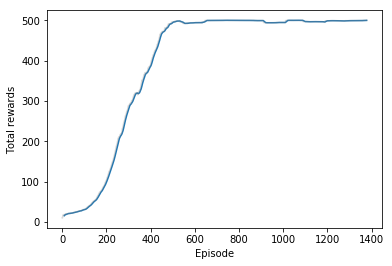

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

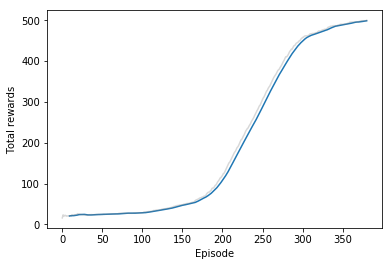

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

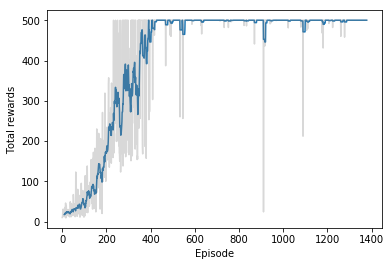

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

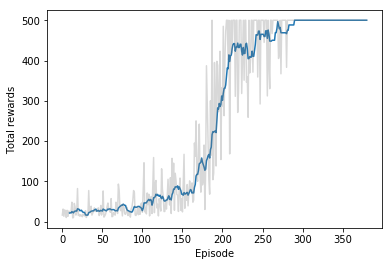

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.